# SARIMA and Auto ARIMA

## Install Package

In [1]:
!pip install pmdarima

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, r2_score
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/cleaned_data.csv', parse_dates=['date'], index_col='date')

In [5]:
df_diff = pd.read_csv('data/data_stationary.csv', parse_dates=['date'], index_col='date')

In [6]:
df_s_d = pd.read_csv('data/data_non_seasonal.csv', parse_dates=['date'], index_col='date')

# Model Building

Before starting with the modeling phase an imporant notion when working on forcasting timeseries is: 
### In-Sample vs Out-of-Sample Predictions

#### In-Sample Predictions
These predictions cover the periods already included in the training data. They help assess how well the model fits historical data, using metrics like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). The predict method is used to generate these values.

#### Out-of-Sample Predictions
These predictions extend beyond the training data, focusing on future periods. They are used for forecasting and trend projection for unseen data. The forecast method is typically applied to obtain these predictions.

---

##### Key Difference:
- **In-Sample**: Validates the model on known data.
- **Out-of-Sample**: Projects the model onto new, unseen time periods.

### SARIMA 
In general, for seasonal time series data, SARIMA are often the better choice than ARIMA because they can directly model the seasonal component. In our case the data have seasonal caracteristics so we will work wit SARIMA a


#### SARIMA vs. SARIMAX

##### SARIMA
SARIMA (Seasonal ARIMA) models time series data with seasonal patterns by combining:
- **AR**: AutoRegressive component (uses past values)
- **I**: Integrated component (makes the series stationary)
- **MA**: Moving Average component (uses past forecast errors)
- **S**: Accounts for seasonal patterns

##### SARIMAX
SARIMAX extends SARIMA by including **exogenous variables (X)**, external factors that might affect the time series (e.g., economic indicators, weather).

##### Key Differences
- **SARIMA**: Uses only past values and seasonal components.
- **SARIMAX**: Includes both seasonal components and external variables.

---

#### ACF and PACF Tests

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are essential tools for identifying the appropriate orders of AR (AutoRegressive) and MA (Moving Average) terms in time series models like ARIMA and SARIMA.

- **ACF** (AutoCorrelation Function) identifies the **MA order** by showing how past residuals affect the current value.
- **PACF** (Partial AutoCorrelation Function) helps determine the **AR order** by showing direct correlations with lags, removing the influence of earlier lags.

##### How to interpret ACF and PACF plots?

- **p** : Count the number of significant lags in the PACF plot. This indicates the order of the AR component (p). A gradual decay in the PACF means that higher p might be required.
- **d** : Number of times differencing is carried out to make the time series stationary.
- **q** : If the ACF decays slowly, the model might need a higher q. If the ACF cuts off after a specific lag (abrupt drop), this indicates the q parameter.
 
 For the seasonal components
 
- **P**  we should look for significant spikes at seasonal lags.
- **D**  The seasonal differencing order is the number of times seasonal differencing is applied to remove seasonality.
- **Q**  the ACF shows spikes at multiples of the seasonal period. For instance, if you have monthly data with yearly seasonality, you might see significant spikes at lags 12, 24, etc.
- **m**  The number of periods in a season represents the seasonal cycle length (e.g., 12 for monthly data with annual seasonality).

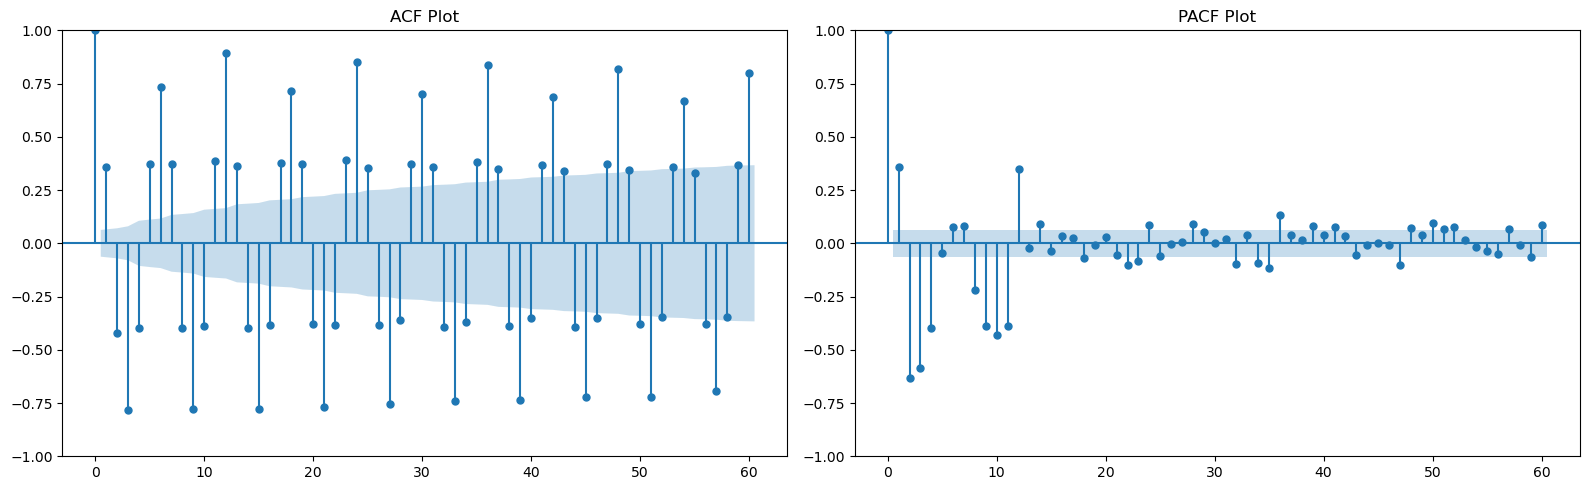

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df_diff, lags=60, ax=axes[0])
axes[0].set_title('ACF Plot')

plot_pacf(df_diff, lags=60, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.tight_layout()
plt.show()

we might need to select higher values of p (AR) and q (MA) values as ACF has slow decay and this might indicate that your series still exhibits some long-range dependencies

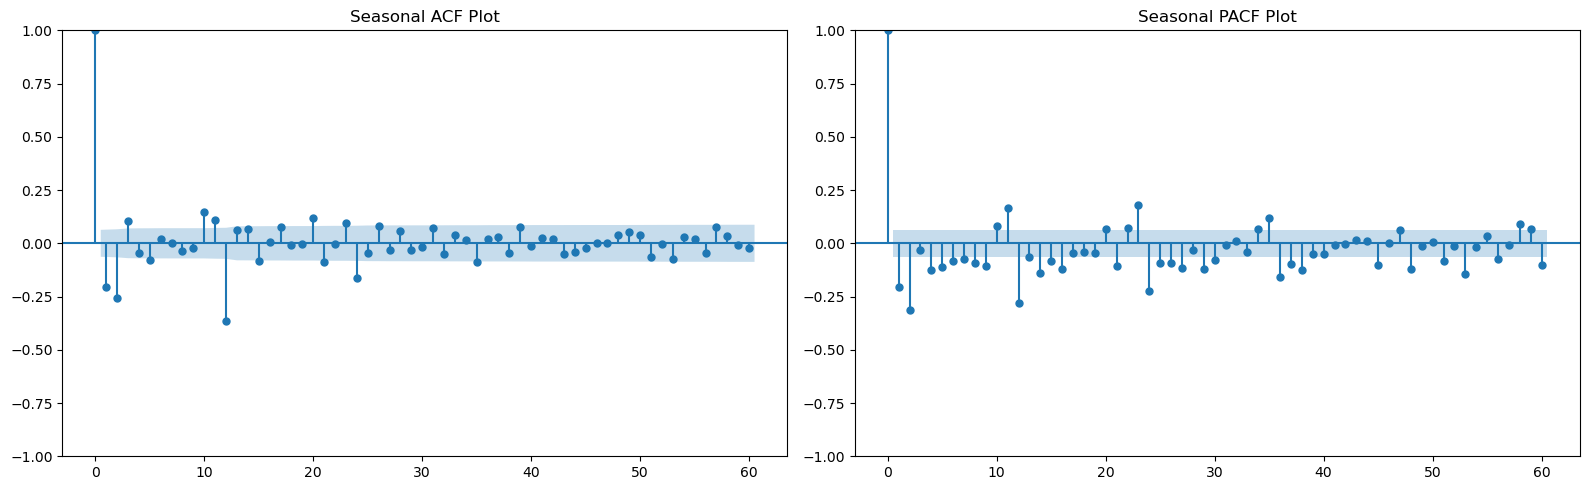

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df_s_d, lags=60, ax=axes[0])
axes[0].set_title('Seasonal ACF Plot')

plot_pacf(df_s_d, lags=60, ax=axes[1])
axes[1].set_title('Seasonal PACF Plot')

plt.tight_layout()
plt.show()

ACF cuts off sharply at a certain seasonal lag of 12

### Explanation of SARIMA Parameters

In this analysis, we determined the following SARIMA parameters:

- **p = 4**, **d = 1**, **q = 3**
- **P = 4**, **D = 1**, **Q = 2**, **m = 12**

#### 1. **Non-Seasonal Parameters (p, d, q)**

- **d = 1 (Differencing order)**: 
  The data was stationary after applying the first differencing (`df.diff()`) wich is why we put it 1.
  
with the slow decay we noticed we can try larger values for p and q 

#### 2. **Seasonal Parameters (P, D, Q, m)**

- **D = 1 (Seasonal differencing order)**: 
  After the original differencing we noticed there is still seasonality so we made seasonal differencing that's why we set it to 1.
  
- **P = around 4 (Seasonal AR order)**: 
  In the seasonal **PACF** plot, we identified peak at lag 12.
  
- **Q = around 2 (Seasonal MA order)**: 
  
- **m = 12 (Seasonal period)**: 
  Since the data is monthly and exhibits annual seasonality, we set **m = 12** to account for the yearly seasonal pattern.





In [9]:
p, d, q = 4, 1, 3
P, D, Q, m = 4, 1, 2, 12

sarima_model = sm.tsa.SARIMAX(
    df['production'], 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Summary of the model
print(sarima_model.summary())


                                        SARIMAX Results                                        
Dep. Variable:                              production   No. Observations:                  972
Model:             SARIMAX(4, 1, 3)x(4, 1, [1, 2], 12)   Log Likelihood               -1784.045
Date:                                 Mon, 16 Dec 2024   AIC                           3596.089
Time:                                         14:08:06   BIC                           3663.431
Sample:                                     01-01-1939   HQIC                          3621.805
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0143      0.171     -5.926      0.000      -1.350      -0

In [29]:
# with open('sarima_model.pkl', 'wb') as f:
#     pickle.dump(sarima_model, f)

## SARIMA Predict

In [10]:
prediction = sarima_model.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

In [11]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

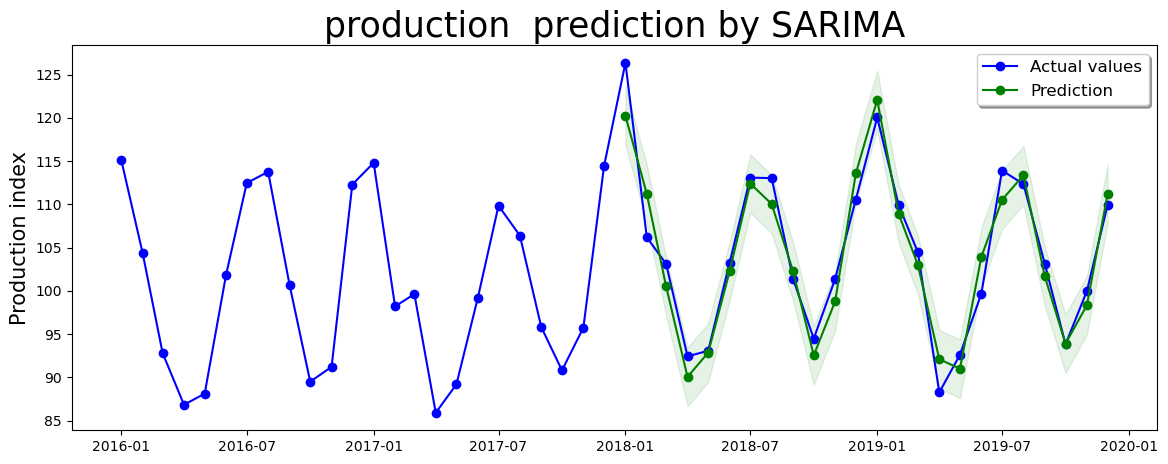

In [12]:
plt.figure(figsize=(14,5))
plt.title("production  prediction by SARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Production index', fontsize=15)
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error

mse = mean_squared_error(df[-24:]['production'], mean_prediction)
print('mse:',mse)
rmse = np.sqrt(mean_squared_error(df[-24:]['production'], mean_prediction))
print('rmse:', rmse)


mse: 6.981074405908433
rmse: 2.642172289217422


## SARIMA Forecast


In [14]:
forecast = sarima_model.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

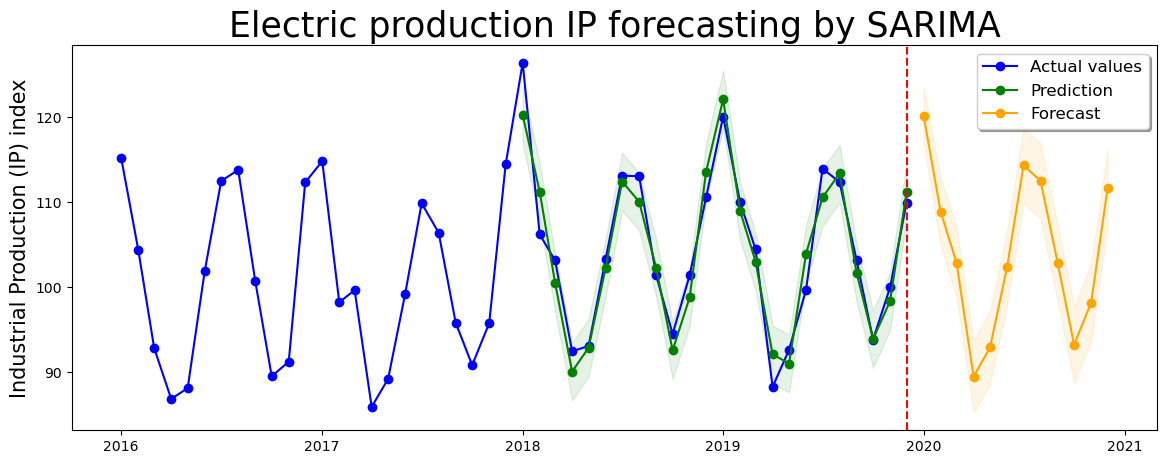

In [15]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

plt.figure(figsize=(14,5))
plt.title("production forecasting by SARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('index', fontsize=15)
plt.show()

For better Results we can  use the triplets of parameters to automate the process of training and evaluating SARIMA models on different combinations (grid search). But with limitation of computation we will just stick with that result.

## AUTO ARIMA

The auto_arima  automatically selects the best model (ARIMA or seasonal ARIMA) by performing model selection based on AIC (Akaike Information Criterion) wich is a great alternative to traditional grid search.

In the `auto_arima` function, you can control the search space for the AR (autoregressive) and MA (moving average) parameters by specifying the minimum and maximum values for `p` (AR) and `q` (MA). This can help improve the model's performance by searching over a targeted range rather than relying on the default settings.

While you can specify these ranges to achieve better results, for computational efficiency, in this example, we will stick with the default search settings and allow `auto_arima` to automatically search for the optimal parameters within its default limits.

example:

model_auto = pm.auto_arima(df['production'], 
                           seasonal=True,  
                           m=12,            
                           stepwise=True,   
                           trace=True,      
                           start_p=1,      
                           end_p=5,         
                           start_q=1,      
                           end_q=5)        

In [18]:
model_auto = pm.auto_arima(df['production'], 
                      seasonal=True,  
                      m=12, 
                      stepwise=True,  
                      trace=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3985.567, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6036.213, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5193.671, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6034.614, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3982.475, Time=4.29 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4057.249, Time=4.91 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=3988.296, Time=4.96 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3981.119, Time=4.34 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=3897.978, Time=4.23 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=4619.332, Time=1.74 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : 

In [30]:
# with open('auto_arima_model.pkl', 'wb') as f:
#     pickle.dump(model_auto, f)

In [24]:
n_periods = 24
start_idx = len(df) - n_periods  
end_idx = len(df) - 1         

past_predictions = model_auto.predict_in_sample(start=start_idx, end=end_idx)

past_prediction_series = pd.Series(
    past_predictions, index=df.index[start_idx:end_idx + 1], name='Past Prediction'
)


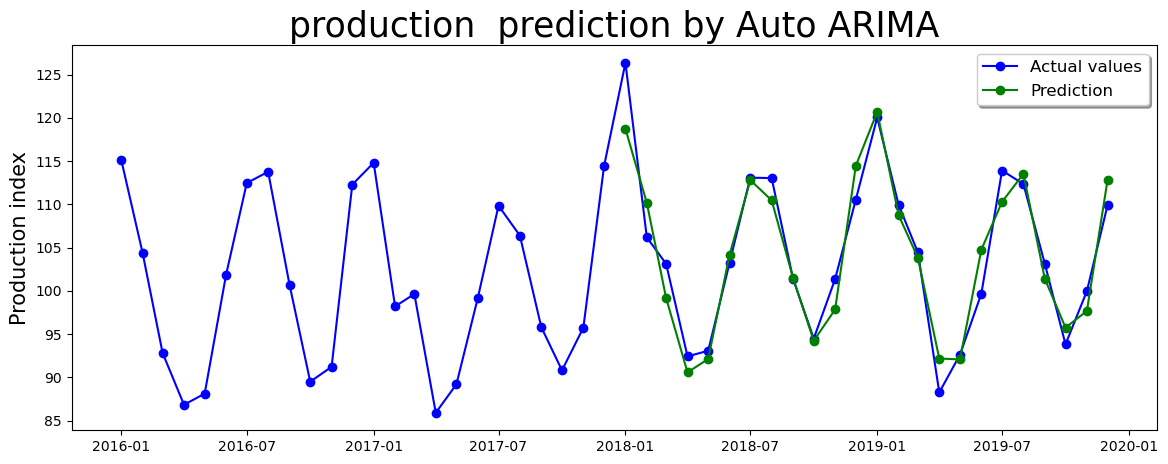

In [31]:


plt.figure(figsize=(14,5))
plt.title("production  prediction by Auto ARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(past_prediction_series[-24:].index, past_prediction_series[-24:].values,label='Prediction', color="green", marker="o")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Production index', fontsize=15)
plt.show()

In [26]:
mse = mean_squared_error(df[-24:]['production'], past_prediction_series)
print('mse:',mse)
rmse = np.sqrt(mean_squared_error(df[-24:]['production'], past_prediction_series))
print('rmse:', rmse)


mse: 8.662420983435949
rmse: 2.9431991069983607


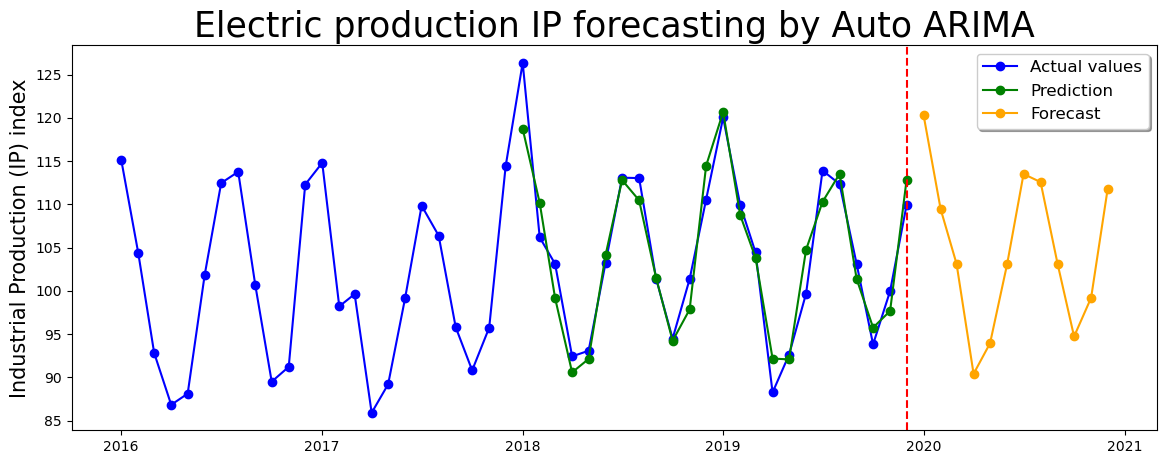

In [27]:
forecast = model_auto.predict(n_periods=12)


plt.figure(figsize=(14,5))
plt.title("production forecasting by Auto ARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(past_predictions[-24:].index, past_predictions[-24:].values,label='Prediction', color="green", marker="o")

plt.plot(forecast[-24:].index,forecast[-24:].values, label='Forecast', color="orange", marker="o")

plt.axvline(df.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Production index', fontsize=15)
plt.show()